# flowline_mesh

This notebook introduces functions we can call for (a) meshing along a centerline, and (b) interpolating data along that centerline. This is done for the purpose of developing a flowline model, which will be done in later notebooks. Required inputs include RGI outlines and centerlines, and either .tif files or .csv files to be read and projected along the centerline. 

## Imports

In [1]:
from dataclasses import dataclass
import firedrake
import geopandas as gpd
import numpy as np
import rasterio
import pandas as pd
from pyproj import Geod
from pathlib import Path
from rasterio.warp import calculate_default_transform, reproject, Resampling
from rasterio.crs import CRS
from rasterio.io import MemoryFile
from scipy.interpolate import interp1d

## interval_mesh

In [2]:
@dataclass
class IntervalMeshResult:
    mesh: firedrake.IntervalMesh
    x: np.ndarray
    y: np.ndarray
    glacier_length: float
    mesh_length: float

def interval_mesh(**kwargs):
    rgiid = kwargs.get('rgiid', '15-09534')
    centerline_path = kwargs['centerline_path']
    outline_path = kwargs['outline_path']
    extra_length = kwargs.get('extra_length', 0)
    n_cells = kwargs['n_cells']

    outlines = gpd.read_file(outline_path)
    centerlines = gpd.read_file(centerline_path)
    outline = outlines[outlines['rgi_id'].str.contains(rgiid)].geometry.values[0]
    centerline = centerlines[centerlines.intersects(outline)].geometry.values[0]

    geod = Geod(ellps = 'WGS84')
    x, y = centerline.xy
    distances = [0] + [geod.inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x) - 1)]
    glacier_length = np.sum(distances)
    length = glacier_length + extra_length

    if extra_length > 0:
        azimuth, _, _ = geod.inv(x[-2], y[-2], x[-1], y[-1])
        x_new, y_new, _ = geod.fwd(x[-1], y[-1], azimuth, extra_length)
        x = np.append(x, x_new)
        y = np.append(y, y_new)
        distances.append(extra_length)

    mesh = firedrake.IntervalMesh(n_cells, length)

    return IntervalMeshResult(
        mesh = mesh,
        x = np.array(x),
        y = np.array(y),
        glacier_length = glacier_length,
        mesh_length = float(length)
    )

## interpolate_to_centerline

In [3]:
@dataclass
class InterpolateResult:
    data: firedrake.Function
    last_nonzero_value: float

def interpolate_to_centerline(**kwargs):
    mesh = kwargs['mesh']
    data_path = kwargs['data_path']
    extension = Path(data_path).suffix
    dimension = kwargs.get('dimension', 1)
    element = kwargs.get('element', 'CG')
    ice_free_value = kwargs.get('ice_free_value', 0)
    key_value = kwargs.get('key_value', 'n/a')
    data_value = kwargs.get('data_value', 'n/a')
    key_dataset = kwargs.get('key_dataset', 'n/a')
    projection = kwargs.get('projection', 'EPSG:4326')

    if extension == '.tif':
        x, y = mesh.x, mesh.y

        with rasterio.open(data_path) as src:
            src_crs = src.crs
            target_crs = CRS.from_string(projection)

            if src_crs != target_crs:
                print(f'Reprojecting {data_path} from {src_crs} to {target_crs}')
                transform, width, height = calculate_default_transform(
                    src_crs, target_crs, src.width, src.height, *src.bounds)

                meta = src.meta.copy()
                meta.update({
                    'crs': target_crs,
                    'transform': transform,
                    'width': width,
                    'height': height
                })

                with MemoryFile() as memfile:
                    with memfile.open(**meta) as dst:
                        for i in range(1, src.count + 1):
                            reproject(
                                source = rasterio.band(src, i),
                                destination = rasterio.band(dst, i),
                                src_transform = src.transform,
                                src_crs = src_crs,
                                dst_transform = transform,
                                dst_crs = target_crs,
                                resampling = Resampling.bilinear
                            )
                    with memfile.open() as reproj:
                        values = np.array(list(reproj.sample(zip(x, y)))).flatten()
            else:
                values = np.array(list(src.sample(zip(x, y)))).flatten()

        distances = np.insert(np.cumsum([Geod(ellps = 'WGS84').inv(x[i], y[i], x[i+1], y[i+1])[2] for i in range(len(x) - 1)]), 0, 0)
        vertex_coords = mesh.mesh.coordinates.dat.data_ro.flatten()
        interp_vals = interp1d(distances, values, bounds_error = False, fill_value = 'extrapolate')(vertex_coords)
        interp_vals[vertex_coords > mesh.glacier_length] = ice_free_value

        V = firedrake.FunctionSpace(mesh.mesh, element, dimension)
        data_function = firedrake.Function(V)
        data_function.dat.data[:] = interp_vals
        last_nonzero = next((v for v in reversed(interp_vals) if v != 0), 0)

        return InterpolateResult(data = data_function, last_nonzero_value = float(last_nonzero))

    elif extension == '.csv':
        data = pd.read_csv(data_path)
        interp_func = interp1d(data[key_value], data[data_value], bounds_error = False, fill_value = 'extrapolate')

        vertex_keys = key_dataset.dat.data_ro
        data_on_mesh = interp_func(vertex_keys)

        V = firedrake.FunctionSpace(mesh.mesh, element, dimension)
        data_function = firedrake.Function(V)
        data_function.dat.data[:] = data_on_mesh

        return InterpolateResult(data = data_function, last_nonzero_value = np.nan)


## Examples

In [4]:
# Paths
base_path = '/eejit/home/bezu0001/data/'
centerline_path = base_path + 'centerlines/RGI2000-v7.0-L-15_south_asia_east/RGI2000-v7.0-L-15_south_asia_east.shp'
outline_path = base_path + 'outlines/RGI2000-v7.0-G-15_south_asia_east/RGI2000-v7.0-G-15_south_asia_east.shp'
thickness_path = base_path + 'bed/Thickness-Farinotti/RGI60-15-02373_latlon.tif'
dem_path = base_path + 'elevation/DEM-SRTMv3/SRTMv3_RGI60-15-02373.tif'
smb_path = base_path + 'smb/prf_glacier_ctl.csv'
velocity_path = base_path + 'velocity/lugge/MedianVelocity_2006_EPSG4326.tif'
velocity_path = base_path + 'velocity/lugge/MedianVelocity_2006.tif'

In [5]:
mesh = interval_mesh(rgiid = '15-09534', centerline_path = centerline_path, outline_path = outline_path, n_cells = 100, extra_length = 1000)

thickness = interpolate_to_centerline(mesh = mesh, data_path = thickness_path, ice_free_value = 0)
dem = interpolate_to_centerline(mesh = mesh, data_path = dem_path, ice_free_value = 0)
bed_val = dem.last_nonzero_value - thickness.last_nonzero_value #obtain the bed value at the last on-glacier location
dem = interpolate_to_centerline(mesh = mesh, data_path = dem_path, ice_free_value = bed_val) #and use it to refine the final on-glacier dem value

smb = interpolate_to_centerline(mesh = mesh, data_path = smb_path, key_value = ' altitude', key_dataset = dem.data, data_value = 'ave_mb')

velocity = interpolate_to_centerline(mesh = mesh, data_path = velocity_path, ice_free_value = 0)

Q = firedrake.FunctionSpace(mesh.mesh, 'CG', 1)
bed = firedrake.Function(Q).project(dem.data - thickness.data)

Reprojecting /eejit/home/bezu0001/data/velocity/lugge/MedianVelocity_2006.tif from EPSG:32646 to EPSG:4326


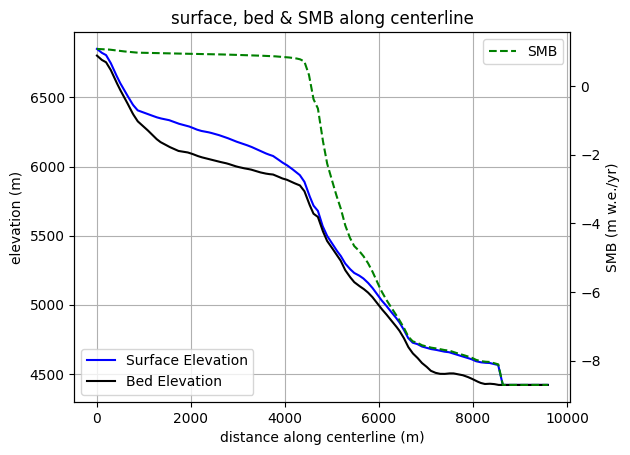

In [6]:
import matplotlib.pyplot as plt
X = np.array([(x,) for x in np.linspace(0, mesh.mesh_length, int(mesh.mesh_length))])

# Sample elevation, thickness, and SMB along the mesh
elevation_profile = np.array(dem.data.at(X, tolerance = 1e-10))
thickness_profile = np.array(thickness.data.at(X, tolerance = 1e-10))
bed_profile = elevation_profile - thickness_profile
smb_profile = np.array(smb.data.at(X, tolerance = 1e-10))

# Plot
fig, ax1 = plt.subplots()
ax1.plot(elevation_profile, color = 'blue', label = 'Surface Elevation')
ax1.plot(bed_profile, color = 'k', label = 'Bed Elevation')
ax1.set_xlabel('distance along centerline (m)')
ax1.set_ylabel('elevation (m)')
ax1.grid(True)
ax1.legend(loc='lower left')

# Add twin axis for SMB
ax2 = ax1.twinx()
ax2.plot(X.flatten(), smb_profile, color = 'green', linestyle = 'dashed', label = 'SMB')
ax2.set_ylabel('SMB (m w.e./yr)')
ax2.legend(loc='upper right')

plt.title('surface, bed & SMB along centerline')
plt.show()

Text(0, 0.5, 'velocity (m per year)')

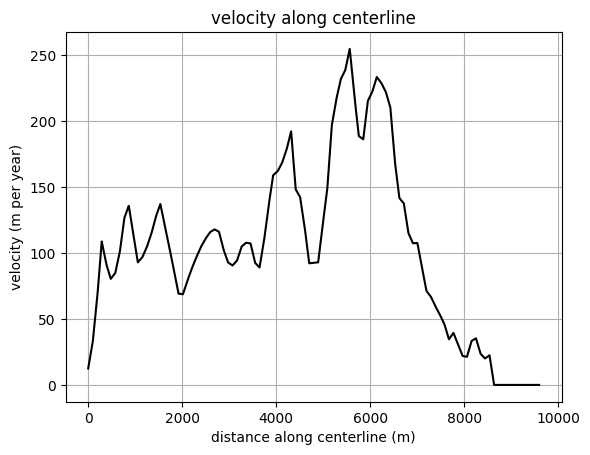

In [7]:
plt.figure()
plt.title('velocity along centerline')
plt.plot(velocity.data.at(X, tolerance = 1e-10), color = 'k')
plt.grid()
plt.xlabel('distance along centerline (m)')
plt.ylabel('velocity (m per year)')